Import GFOC dataset filtered for orbital decay

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def find_repo_root(marker="README.md"):
    """Walk up from current path to find the repo root containing `marker`."""
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent
    raise FileNotFoundError(f"Could not find repo root with marker '{marker}'")

# Find repo root using a known file at the root
repo_root = find_repo_root("README.md")

# Path to the CSV file
GFOC_path = repo_root / Path('Dataset/Dataset_MSc/GFOC_RDCDFI.csv')

# Load only specific columns that you need for analysis
# This will significantly reduce memory usage
columns_needed = ['time', 'orbital_decay', 'se_orbital_decay']

# Try to load with limited columns first
try:
    GFOC_data = pd.read_csv(GFOC_path, usecols=columns_needed, low_memory=True)
    print(f"Successfully loaded data with shape: {GFOC_data.shape}")
except MemoryError:
    print("Still running out of memory. Loading in chunks...")
    # If still out of memory, load in chunks
    chunk_list = []
    chunksize = 50000  # Adjust this number based on your available memory
    
    for chunk in pd.read_csv(GFOC_path, usecols=columns_needed, chunksize=chunksize, low_memory=True):
        chunk_list.append(chunk)
    
    GFOC_data = pd.concat(chunk_list, ignore_index=True)
    print(f"Successfully loaded data in chunks with shape: {GFOC_data.shape}")

Successfully loaded data with shape: (1486079, 3)


Savitsky-Golay filter as a comparison

In [ ]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth the data
window_length = 120001  # Must be odd and less than the length of the data
polyorder = 3  # Polynomial order for the filter
# append smoothed data to the DataFrame
GFOC_data['orbital_decay_savgol'] = savgol_filter(GFOC_data['orbital_decay'].values, window_length, polyorder)

Create a simple plot with time and orbital decay

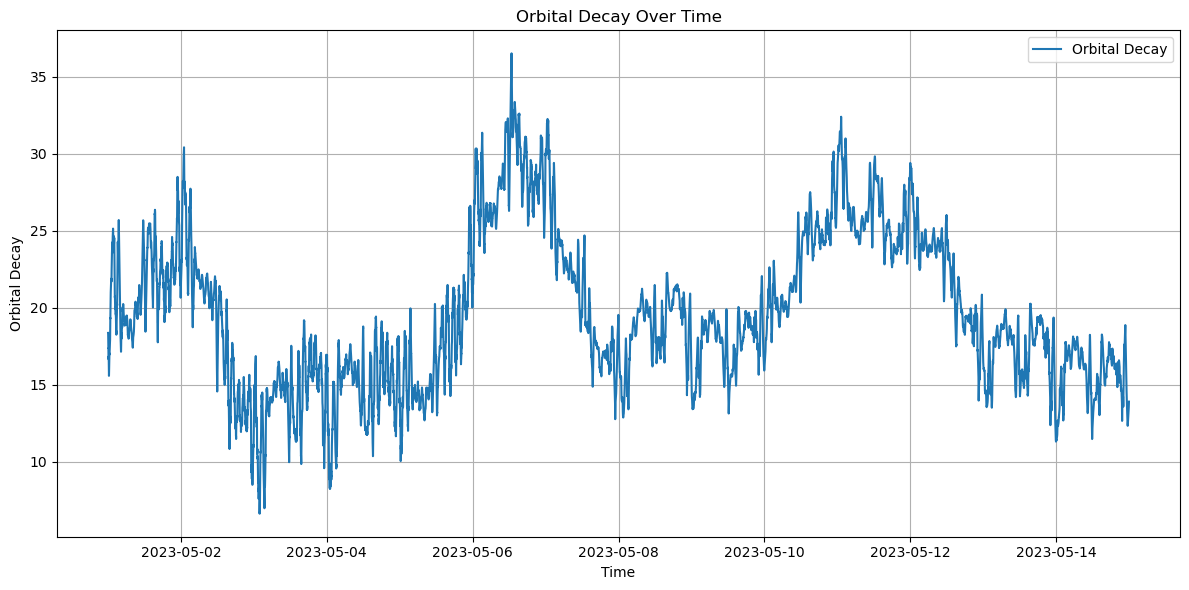

In [ ]:
import matplotlib.dates as mdates
import numpy as np

# =========================== Input ===================================
start_date = '2023-05-01 00:00:00'
end_date = '2023-05-15 00:00:00'
# start_date = GFOC_data['time'].values[0]
# end_date = GFOC_data['time'].values[-1]

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# plt.style.use('dark_background')
plt.style.use('default')

# =====================================================================


GFOC_subset = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]
# Time conversion
GFOC_time = GFOC_subset['time']
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')

# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))                         
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=0)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(GFOC_time, GFOC_subset['orbital_decay'], label='Orbital Decay')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


I want to create a Lowess trend and to compare it to a linear trend. Testing of different fractions.

Here is what Vanessa wrote about Lowess:

_"Regarding the lowess smoother I mentioned for trend finding: A regular linear fit would be heavily impacted by outliers since it would_

1. _account equally for nearby and far-away points_
2. _account equally for points that yield high residuals (e.g. the 3-sigma deviated decays during the strong event)._

_With lowess, which is basically just weighted linear regression in local intervals, these are both alleviated. There is one main parameter called `frac` (fraction of the data used in the fit). For `frac=1`, all the data is used for the estimation. `Frac * len(data)` closest points to the current point `(xi, yi)` to estimate are considered, and their contribution to the fit is weighted by their distance to `xi`. In addition, lowess accounts for a secondary weighting, namely by multipling the distance weights by the bisquare function of the corresponding residual at `xi`. As a result, points with high residuals = outliers end up having very low weights. This is one way I could think of finding the trend, but I’m very open to hearing your ideas if you may have others."_

In [4]:
# ! Takes a while to run, so only run this if you want to see the LOWESS smoothed data

import statsmodels.api as sm

lowess = sm.nonparametric.lowess
x = GFOC_time.astype(np.int64) // 10**9  # Convert to seconds for LOWESS
y = GFOC_subset['orbital_decay'].values
z = lowess(y, x) # frac=2./3 is default
# w = lowess(y, x, frac=1./3)
# v = lowess(y, x, frac=1.)


Plot

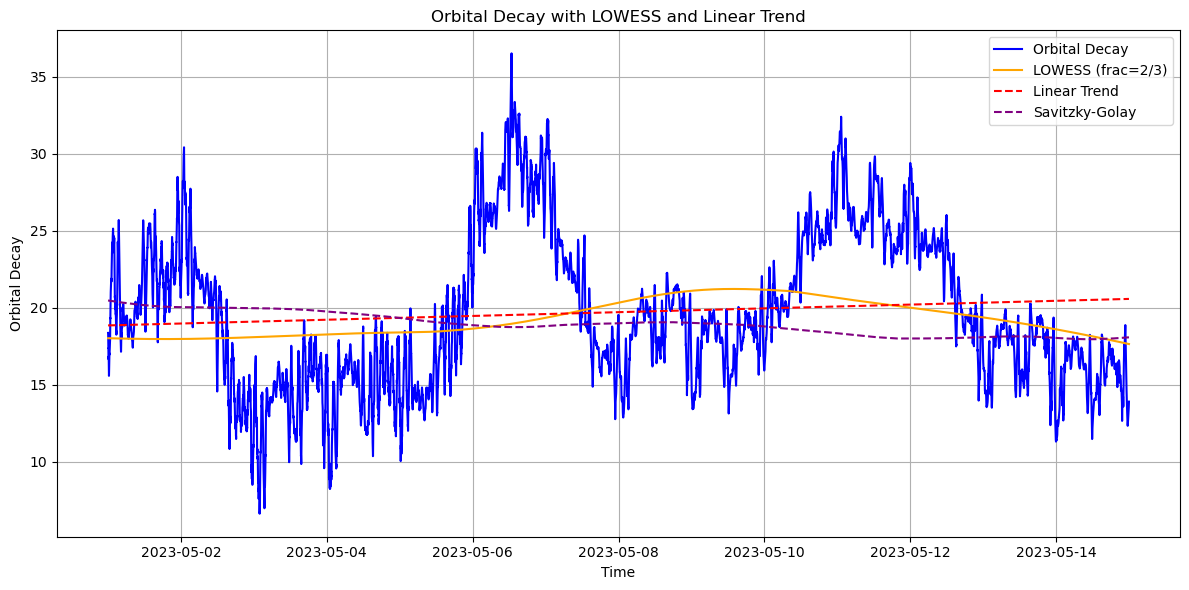

In [6]:
from sklearn.linear_model import LinearRegression


# Prepare data for linear regression
x_numeric = x.values.reshape(-1, 1)  # x is already in seconds
y_numeric = y

# Fit linear regression
linreg = LinearRegression()
linreg.fit(x_numeric, y_numeric)
y_lin_trend = linreg.predict(x_numeric)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(GFOC_time, GFOC_subset['orbital_decay'], label='Orbital Decay', color='blue')
# ax.plot(GFOC_time, v[:, 1], label='LOWESS (frac=1)', color='cyan')
ax.plot(GFOC_time, z[:, 1], label='LOWESS (frac=2/3)', color='orange')
# ax.plot(GFOC_time, w[:, 1], label='LOWESS (frac=1/3)', color='green')
ax.plot(GFOC_time, y_lin_trend, label='Linear Trend', color='red', linestyle='--')
ax.plot(GFOC_time, GFOC_subset['orbital_decay_savgol'], label='Savitzky-Golay', color='purple', linestyle='--')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay with LOWESS and Linear Trend')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Findings

- Lowess is less influenced by extreme events compared to a linear regression trend.
- for this time range the default `frac` (`frac=2./3`) value performs better than `frac=1./3`.
- For this time range the linear trend is similar to the Savitsky-Golay filter.
- Lowess is extremly expensive compared to linear regression and Savitsky-Golay filter.

## Open Problems
- Performance over whole time range
- Removal of other trends from the decays (solar cycle, ...)

## Next tasks
- look at the period spectrum of decay rates and assess if and how the solar rotation period could be cleaned from the data; additionally assess if the remaining higher frequency variations are significant (those at ~5 days).
- review the work already done on assessing subset lengths relevant for computing statistics - review outcomes and document briefly both positive and/or negative findings.